In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import os
from pyspark.sql.functions import col, lit, lag, to_date, date_format, split, when, coalesce, year, count, expr, udf, sum, year, floor, rank, round, regexp_extract, avg
from pyspark.sql.types import MapType, StringType
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain
from pyspark.sql.window import Window
import numpy as np
import matplotlib.ticker as ticker
from itertools import chain

In [2]:
spark = SparkSession.builder \
                    .appName('tennis') \
                    .getOrCreate()

In [3]:
folders = ["singles/", "doubles/", "futures/", "qual_chal/"]
file_columns = []
files65 = []
files49= []

In [4]:
for folder in folders:
    for filename in os.listdir(folder):
    
        file_path = os.path.join(folder, filename)
        df = spark.read.option("header", "true") \
                       .option("inferSchema", "true") \
                       .csv(file_path)
        
        #file_columns.append({filename:df.columns})
        file_columns.append(df.columns)
        if len(df.columns) == 65:
            files65.append(filename)
        else:
            files49.append(filename)

In [5]:
# Removing duplicates
file_columns = list(set(map(tuple, file_columns)))
file_columns = [list(item) for item in file_columns]
file_columns

[['tourney_id',
  'tourney_name',
  'surface',
  'draw_size',
  'tourney_level',
  'tourney_date',
  'match_num',
  'winner_id',
  'winner_seed',
  'winner_entry',
  'winner_name',
  'winner_hand',
  'winner_ht',
  'winner_ioc',
  'winner_age',
  'loser_id',
  'loser_seed',
  'loser_entry',
  'loser_name',
  'loser_hand',
  'loser_ht',
  'loser_ioc',
  'loser_age',
  'score',
  'best_of',
  'round',
  'minutes',
  'w_ace',
  'w_df',
  'w_svpt',
  'w_1stIn',
  'w_1stWon',
  'w_2ndWon',
  'w_SvGms',
  'w_bpSaved',
  'w_bpFaced',
  'l_ace',
  'l_df',
  'l_svpt',
  'l_1stIn',
  'l_1stWon',
  'l_2ndWon',
  'l_SvGms',
  'l_bpSaved',
  'l_bpFaced',
  'winner_rank',
  'winner_rank_points',
  'loser_rank',
  'loser_rank_points'],
 ['tourney_id',
  'tourney_name',
  'surface',
  'draw_size',
  'tourney_level',
  'tourney_date',
  'match_num',
  'winner1_id',
  'winner2_id',
  'winner_seed',
  'winner_entry',
  'loser1_id',
  'loser2_id',
  'loser_seed',
  'loser_entry',
  'score',
  'best_of',
 

In [6]:
print(f"Number of different column sets: {len(file_columns)}")
print(f"Number of columns in the first set: {len(file_columns[0])}")
print(f"Number of columns in the second set: {len(file_columns[1])}")

Number of different column sets: 2
Number of columns in the first set: 49
Number of columns in the second set: 65


In [7]:
col1 = set(file_columns[0])
col2 = set(file_columns[1])
diff1 = col1 - col2 # Columns in Doubles files that are not in Singles files
diff2 = col2 - col1 # Columns in Singles files that are not in Doubles files
# ^ to get both

In [8]:
diff1

{'loser_age',
 'loser_hand',
 'loser_ht',
 'loser_id',
 'loser_ioc',
 'loser_name',
 'loser_rank',
 'loser_rank_points',
 'winner_age',
 'winner_hand',
 'winner_ht',
 'winner_id',
 'winner_ioc',
 'winner_name',
 'winner_rank',
 'winner_rank_points'}

In [9]:
diff2

{'loser1_age',
 'loser1_hand',
 'loser1_ht',
 'loser1_id',
 'loser1_ioc',
 'loser1_name',
 'loser1_rank',
 'loser1_rank_points',
 'loser2_age',
 'loser2_hand',
 'loser2_ht',
 'loser2_id',
 'loser2_ioc',
 'loser2_name',
 'loser2_rank',
 'loser2_rank_points',
 'winner1_age',
 'winner1_hand',
 'winner1_ht',
 'winner1_id',
 'winner1_ioc',
 'winner1_name',
 'winner1_rank',
 'winner1_rank_points',
 'winner2_age',
 'winner2_hand',
 'winner2_ht',
 'winner2_id',
 'winner2_ioc',
 'winner2_name',
 'winner2_rank',
 'winner2_rank_points'}

In [10]:
# Files with 65 columns
files65

['atp_matches_doubles_2007.csv',
 'atp_matches_doubles_2019.csv',
 'atp_matches_doubles_2012.csv',
 'atp_matches_doubles_2018.csv',
 'atp_matches_doubles_2020.csv',
 'atp_matches_doubles_2011.csv',
 'atp_matches_doubles_2016.csv',
 'atp_matches_doubles_2000.csv',
 'atp_matches_doubles_2017.csv',
 'atp_matches_doubles_2008.csv',
 'atp_matches_doubles_2004.csv',
 'atp_matches_doubles_2013.csv',
 'atp_matches_doubles_2009.csv',
 'atp_matches_doubles_2001.csv',
 'atp_matches_doubles_2006.csv',
 'atp_matches_doubles_2014.csv',
 'atp_matches_doubles_2003.csv',
 'atp_matches_doubles_2015.csv',
 'atp_matches_doubles_2010.csv',
 'atp_matches_doubles_2005.csv',
 'atp_matches_doubles_2002.csv']

In [11]:
# Files with 49 columns
files49

['atp_matches_1984.csv',
 'atp_matches_2009.csv',
 'atp_matches_2022.csv',
 'atp_matches_1990.csv',
 'atp_matches_2016.csv',
 'atp_matches_2017.csv',
 'atp_matches_2001.csv',
 'atp_matches_2007.csv',
 'atp_matches_1985.csv',
 'atp_matches_1971.csv',
 'atp_matches_2013.csv',
 'atp_matches_2021.csv',
 'atp_matches_1991.csv',
 'atp_matches_1992.csv',
 'atp_matches_1979.csv',
 'atp_matches_2003.csv',
 'atp_matches_1968.csv',
 'atp_matches_1994.csv',
 'atp_matches_2004.csv',
 'atp_matches_1987.csv',
 'atp_matches_2010.csv',
 'atp_matches_2018.csv',
 'atp_matches_1981.csv',
 'atp_matches_2005.csv',
 'atp_matches_1989.csv',
 'atp_matches_1978.csv',
 'atp_matches_2002.csv',
 'atp_matches_1970.csv',
 'atp_matches_1998.csv',
 'atp_matches_1975.csv',
 'atp_matches_1980.csv',
 'atp_matches_2015.csv',
 'atp_matches_1996.csv',
 'atp_matches_2006.csv',
 'atp_matches_1988.csv',
 'atp_matches_1997.csv',
 'atp_matches_2008.csv',
 'atp_matches_1973.csv',
 'atp_matches_1974.csv',
 'atp_matches_1976.csv',


In [12]:
singles=spark.read.option("header","true").option("inferSchema","true") \
.csv('singles')

singles = singles.withColumn(
    "Origin",
    lit('Singles')
)

doubles=spark.read.option("header","true").option("inferSchema","true") \
.csv('doubles')

doubles = doubles.withColumn(
    "Origin",
    lit('Doubles')
)

futures=spark.read.option("header","true").option("inferSchema","true") \
.csv('futures')

futures = futures.withColumn(
    "Origin",
    lit('Futures')
)

qual_chal = spark.read.option("header","true").option("inferSchema","true") \
.csv('qual_chal')

qual_chal = qual_chal.withColumn(
    "Origin",
    lit('Qualificacao_Challenger')
)

amat = spark.read.option("header","true").option("inferSchema","true") \
.csv('atp_matches_amateur.csv')

amat = amat.withColumn(
    "Origin",
    lit('Amateur')
)

In [13]:
matches_completos = singles.unionAll(futures)
matches_completos = matches_completos.unionAll(qual_chal)
matches_completos=matches_completos.unionAll(amat)

In [14]:
colunas_unicas_doubles = list(set(doubles.columns) - set(matches_completos.columns))

for a in colunas_unicas_doubles:
    matches_completos = matches_completos.withColumn(
    a,
    lit(None)
)

sorted_columns = sorted(matches_completos.columns)
matches_completos = matches_completos.select(*sorted_columns)

In [15]:
colunas_unicas_matches_completos = list(set(matches_completos.columns) - set(doubles.columns))

for a in colunas_unicas_matches_completos:
    doubles = doubles.withColumn(
    a,
    lit(None)
)

In [16]:
sorted_columns = sorted(doubles.columns)
doubles = doubles.select(*sorted_columns)
matches_completos=matches_completos.unionAll(doubles)

In [17]:
len(matches_completos.columns)

82

In [18]:
matches_completos.select('tourney_id').show()
matches=matches_completos

+----------+
|tourney_id|
+----------+
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
|  1994-339|
+----------+
only showing top 20 rows



In [19]:
# Listing all columns with the type 'void' and converting to int
void_columns = [col_name for col_name, data_type in matches.dtypes if data_type == 'void']
for col_name in void_columns:
    matches = matches.withColumn(col_name, matches[col_name].cast("int"))

In [20]:
# Converting to int
columns_to_convert = ["draw_size", "loser_id","loser_seed", "best_of", "minutes", "winner_seed",
    "w_ace", "w_df", "w_svpt", "w_1stIn", "w_1stWon", "w_2ndWon", "w_SvGms", "w_bpSaved", "w_bpFaced",
    "l_ace", "l_df", "l_svpt", "l_1stIn", "l_1stWon", "l_2ndWon", "l_SvGms", "l_bpSaved", "l_bpFaced",
    "winner_rank", "loser_rank", "winner_rank_points", "loser_rank_points", "winner2_hand"
]
for column in columns_to_convert:
    matches = matches.withColumn(column, col(column).cast("integer"))

In [21]:
matches = matches.withColumn("tourney_date", to_date(matches["tourney_date"].cast("string"), "yyyyMMdd"))
matches = matches.withColumn("winner_age", matches["winner_age"].cast("double"))

In [22]:
# Function to get scores for each set
def extrair_sets(scores):
    if scores:
        sets = scores.split(' ')
    else:
        sets = []
    set_values = {}

    if sets:
        for i, set_score in enumerate(sets):
            try:
                set_values[f"set_{i+1}"] = int(set_score)
            except ValueError:
                set_values[f"set_{i+1}"] = set_score

    return set_values

extrair_sets_udf = udf(extrair_sets, MapType(StringType(), StringType()))

# New column with the scores for each set
matches = matches.withColumn("sets", extrair_sets_udf(col("score")))
for i in range(1, 6):  
    matches = matches.withColumn(f"set_{i}", when(col("sets").getItem(f"set_{i}").isNull(), None).otherwise(col("sets").getItem(f"set_{i}")))

matches = matches.drop("sets")

In [23]:
matches.select("set_1", "set_2", "set_3", "set_4", "set_5").show(10)

+------+------+-----+-----+-----+
| set_1| set_2|set_3|set_4|set_5|
+------+------+-----+-----+-----+
|   6-2|   6-2| NULL| NULL| NULL|
|   6-3|   4-6|  6-2| NULL| NULL|
|   6-4|   6-3| NULL| NULL| NULL|
|   6-3|   6-2| NULL| NULL| NULL|
|   6-4|   6-2| NULL| NULL| NULL|
|   4-6|   6-1|  6-3| NULL| NULL|
|6-7(3)|   6-3|  6-4| NULL| NULL|
|   6-4|   6-4| NULL| NULL| NULL|
|   6-2|   7-5| NULL| NULL| NULL|
|   6-2|7-6(2)| NULL| NULL| NULL|
+------+------+-----+-----+-----+
only showing top 10 rows



In [24]:
matches.filter(matches["set_5"].isNotNull()).select("set_5").show(10)

+-----+
|set_5|
+-----+
|  6-1|
|  8-6|
|  6-2|
|  6-4|
|  6-2|
|  8-6|
|  6-3|
|  RET|
|  6-2|
|  6-4|
+-----+
only showing top 10 rows



In [25]:
matches.printSchema()

root
 |-- Origin: string (nullable = false)
 |-- best_of: integer (nullable = true)
 |-- draw_size: integer (nullable = true)
 |-- l_1stIn: integer (nullable = true)
 |-- l_1stWon: integer (nullable = true)
 |-- l_2ndWon: integer (nullable = true)
 |-- l_SvGms: integer (nullable = true)
 |-- l_ace: integer (nullable = true)
 |-- l_bpFaced: integer (nullable = true)
 |-- l_bpSaved: integer (nullable = true)
 |-- l_df: integer (nullable = true)
 |-- l_svpt: integer (nullable = true)
 |-- loser1_age: double (nullable = true)
 |-- loser1_hand: string (nullable = true)
 |-- loser1_ht: integer (nullable = true)
 |-- loser1_id: integer (nullable = true)
 |-- loser1_ioc: string (nullable = true)
 |-- loser1_name: string (nullable = true)
 |-- loser1_rank: integer (nullable = true)
 |-- loser1_rank_points: integer (nullable = true)
 |-- loser2_age: double (nullable = true)
 |-- loser2_hand: string (nullable = true)
 |-- loser2_ht: integer (nullable = true)
 |-- loser2_id: integer (nullable = tr

In [26]:
doubles_columns = ['winner1_age', 'winner1_hand', 'winner1_ht', 'winner1_id', 'winner1_ioc', 'winner1_name', 'winner1_rank', 'winner1_rank_points', 'loser1_age', 'loser1_hand', 'loser1_ht', 'loser1_id', 'loser1_ioc', 'loser1_name', 'loser1_rank', 'loser1_rank_points']
singles_columns = ['winner_age', 'winner_hand', 'winner_ht', 'winner_id', 'winner_ioc', 'winner_name', 'winner_rank', 'winner_rank_points', 'loser_age', 'loser_hand', 'loser_ht', 'loser_id', 'loser_ioc', 'loser_name', 'loser_rank', 'loser_rank_points']

In [27]:
# Transferring the records in singles-related columns to doubles-related columns
for i in range(len(doubles_columns)):
    matches = matches.withColumn(f"{doubles_columns[i]}", coalesce(matches[f"{singles_columns[i]}"], matches[f"{doubles_columns[i]}"]))

In [28]:
# Dropping the columns not needed
original_matches = matches
matches = matches.drop(*singles_columns)

In [29]:
# 65 + Origin + 5 sets = 71
len(matches.columns)

71

In [30]:
matches

DataFrame[Origin: string, best_of: int, draw_size: int, l_1stIn: int, l_1stWon: int, l_2ndWon: int, l_SvGms: int, l_ace: int, l_bpFaced: int, l_bpSaved: int, l_df: int, l_svpt: int, loser1_age: double, loser1_hand: string, loser1_ht: int, loser1_id: int, loser1_ioc: string, loser1_name: string, loser1_rank: int, loser1_rank_points: int, loser2_age: double, loser2_hand: string, loser2_ht: int, loser2_id: int, loser2_ioc: string, loser2_name: string, loser2_rank: int, loser2_rank_points: int, loser_entry: string, loser_seed: int, match_num: int, minutes: int, round: string, score: string, surface: string, tourney_date: date, tourney_id: string, tourney_level: string, tourney_name: string, w_1stIn: int, w_1stWon: int, w_2ndWon: int, w_SvGms: int, w_ace: int, w_bpFaced: int, w_bpSaved: int, w_df: int, w_svpt: int, winner1_age: double, winner1_hand: string, winner1_ht: int, winner1_id: int, winner1_ioc: string, winner1_name: string, winner1_rank: int, winner1_rank_points: int, winner2_age: 

In [31]:
print("-------------------------------------------")
# Nulls in 'Origin' column
null_count = matches.select('Origin').where(col('Origin').isNull()).count()
# Count total values set_1
total_values = matches.select('set_1').count()
print(f"Total null values in 'Origin' column: {null_count}")
print(f"Total values in 'set_1' column: {total_values}")
print("-------------------------------------------")

# Only use until winnner_seed, set_1, set_2, etc... were throwing errors
relevant_columns = matches.columns[: matches.columns.index('winner_seed') + 1]

# Null values counts
null_columns = []
for column in relevant_columns:
    null_value_counts = matches.select(column).where(col(column).isNull()).count()
    percentage = (null_value_counts / matches.select(column).count()) * 100
    print(f"Column name: {column} has a total of {null_value_counts} null values and percentage of nulls: {percentage:.2f}%")
    
    # If percentage of nulls superior to 75% delete column?
    if percentage >= 75:
        null_columns.append(column)

print("-------------------------------------------")
print("Columns with null percentage superior to 75%")
for column_null in null_columns:
    print(f"Column name: {column_null}")

-------------------------------------------
Total null values in 'Origin' column: 0
Total values in 'set_1' column: 935359
-------------------------------------------
Column name: Origin has a total of 0 null values and percentage of nulls: 0.00%
Column name: best_of has a total of 0 null values and percentage of nulls: 0.00%
Column name: draw_size has a total of 2477 null values and percentage of nulls: 0.26%
Column name: l_1stIn has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_1stWon has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_2ndWon has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_SvGms has a total of 730170 null values and percentage of nulls: 78.06%
Column name: l_ace has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_bpFaced has a total of 730169 null values and percentage of nulls: 78.06%
Column name: l_bpSaved has a total of 730169 null values and p

In [32]:
matches.repartition(1).write.csv("matches", mode='overwrite')

In [33]:
matches.printSchema()

root
 |-- Origin: string (nullable = false)
 |-- best_of: integer (nullable = true)
 |-- draw_size: integer (nullable = true)
 |-- l_1stIn: integer (nullable = true)
 |-- l_1stWon: integer (nullable = true)
 |-- l_2ndWon: integer (nullable = true)
 |-- l_SvGms: integer (nullable = true)
 |-- l_ace: integer (nullable = true)
 |-- l_bpFaced: integer (nullable = true)
 |-- l_bpSaved: integer (nullable = true)
 |-- l_df: integer (nullable = true)
 |-- l_svpt: integer (nullable = true)
 |-- loser1_age: double (nullable = true)
 |-- loser1_hand: string (nullable = true)
 |-- loser1_ht: integer (nullable = true)
 |-- loser1_id: integer (nullable = true)
 |-- loser1_ioc: string (nullable = true)
 |-- loser1_name: string (nullable = true)
 |-- loser1_rank: integer (nullable = true)
 |-- loser1_rank_points: integer (nullable = true)
 |-- loser2_age: double (nullable = true)
 |-- loser2_hand: string (nullable = true)
 |-- loser2_ht: integer (nullable = true)
 |-- loser2_id: integer (nullable = tr

##### Distribution of player ages (Winners and Losers) 

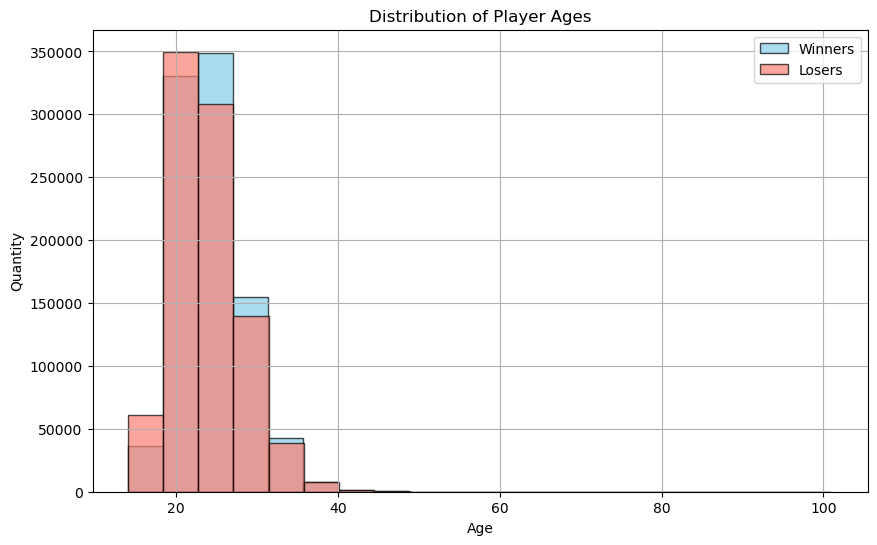

In [34]:
# Drop Null values for age
winner_age_data = matches.select('winner1_age').dropna()
loser_age_data = matches.select('loser1_age').dropna()

winner_age_pandas = winner_age_data.toPandas()
loser_age_pandas = loser_age_data.toPandas()

plt.figure(figsize=(10, 6))
plt.hist(winner_age_pandas['winner1_age'], bins=20, color='skyblue', edgecolor='black', alpha=0.7, label='Winners')
plt.hist(loser_age_pandas['loser1_age'], bins=20, color='salmon', edgecolor='black', alpha=0.7, label='Losers')
plt.title('Distribution of Player Ages')
plt.xlabel('Age')
plt.ylabel('Quantity')
plt.legend()
plt.grid(True)
plt.show()

##### Distribution of tournament types (Grand Slams, ATP Tour, Challengers, Futures) - Ver se dá para fazer separação para homem e para mulher

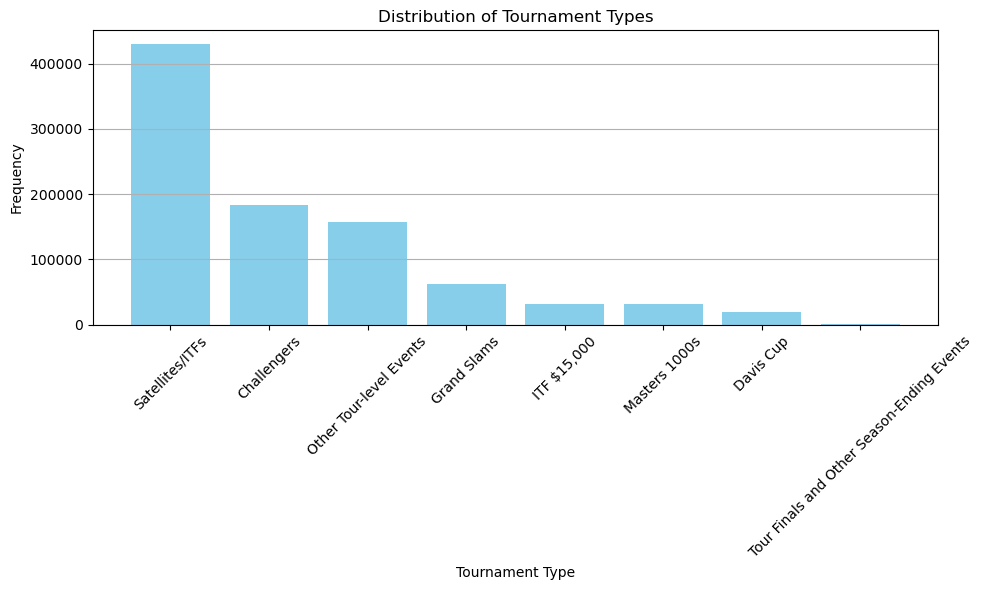

In [35]:
tournament_level_mapping = {
    'G': 'Grand Slams',
    'M': 'Masters 1000s',
    'A': 'Other Tour-level Events',
    'C': 'Challengers',
    'S': 'Satellites/ITFs',
    'F': 'Tour Finals and Other Season-Ending Events',
    'D': 'Davis Cup',
    'P': 'Premier',
    'PM': 'Premier Mandatory',
    'I': 'International',
    '15': 'ITF $15,000',
}

matches_tourney = matches.withColumn('tourney_level_desc', F.create_map([F.lit(x) for x in chain(*tournament_level_mapping.items())])[F.col('tourney_level')])

matches_tourney = matches_tourney.filter(matches_tourney['tourney_level_desc'].isNotNull())

tournament_type_counts = matches_tourney.groupby('tourney_level_desc').count().orderBy('count', ascending=False)
tournament_type_counts_pandas = tournament_type_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(tournament_type_counts_pandas['tourney_level_desc'], tournament_type_counts_pandas['count'], color='skyblue')
plt.title('Distribution of Tournament Types')
plt.xlabel('Tournament Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### Analysis of dominant hand (right-handed vs. left-handed)

Total Winners:
  winner1_hand   count
1            A     288
2            L  105252
3            R  698478
4            U  111876

Total Losers:
  loser1_hand   count
1           A     303
2           L   92345
3           R  650215
4           U  171427


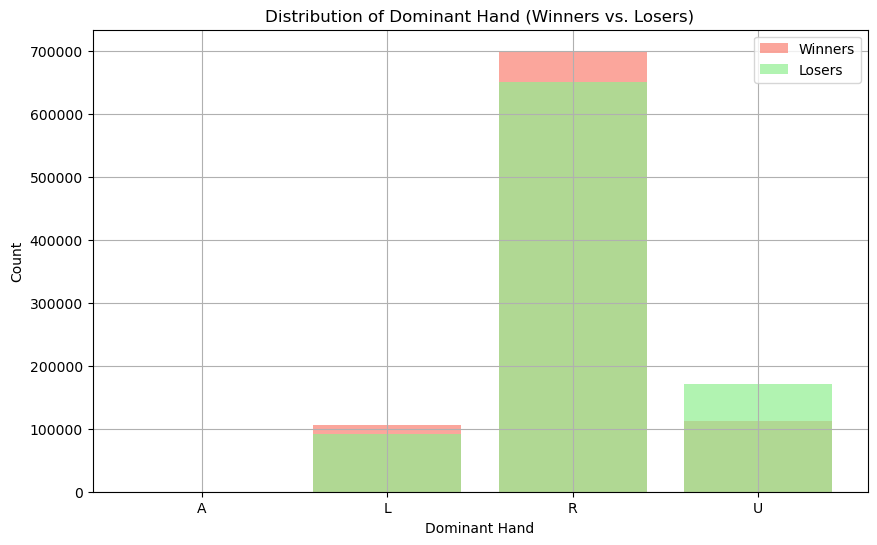

In [36]:
# Grouping by the winner's hand and count
winner_hand_counts = matches.groupBy('winner1_hand').count().orderBy('winner1_hand')
loser_hand_counts = matches.groupBy('loser1_hand').count().orderBy('loser1_hand')

# Pandas Df
winner_hand_pandas = winner_hand_counts.toPandas()
loser_hand_pandas = loser_hand_counts.toPandas()

# Filtering out NaNs
winner_hand_pandas_filtered = winner_hand_pandas.dropna(subset=['winner1_hand'])
loser_hand_pandas_filtered = loser_hand_pandas.dropna(subset=['loser1_hand'])

# Total number of winners and losers for each hand
total_winners = winner_hand_pandas_filtered['count'].sum()
total_losers = loser_hand_pandas_filtered['count'].sum()

print("Total Winners:")
print(winner_hand_pandas_filtered)
print("\nTotal Losers:")
print(loser_hand_pandas_filtered)

winner_color = 'salmon'
loser_color = 'lightgreen'

plt.figure(figsize=(10, 6))
plt.bar(winner_hand_pandas_filtered['winner1_hand'], winner_hand_pandas_filtered['count'], color=winner_color, alpha=0.7, label='Winners')
plt.bar(loser_hand_pandas_filtered['loser1_hand'], loser_hand_pandas_filtered['count'], color=loser_color, alpha=0.7, label='Losers')
plt.title('Distribution of Dominant Hand (Winners vs. Losers)')
plt.xlabel('Dominant Hand')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.show()

In [37]:
from pyspark.sql.functions import sum as spark_sum

##### Roger Federer vs Rafael Nadal. Wins for each one / percentage on each surface.

Win percentage for Roger Federer by surface:
+-------+-------------+-------------+-----------------+------------------+
|surface|total_wins_rf|total_wins_rn|win_percentage_rf| win_percentage_rn|
+-------+-------------+-------------+-----------------+------------------+
|   Hard|           12|            9|57.14285714285714|42.857142857142854|
|   Clay|            2|           14|             12.5|              87.5|
|  Grass|            3|            1|             75.0|              25.0|
+-------+-------------+-------------+-----------------+------------------+



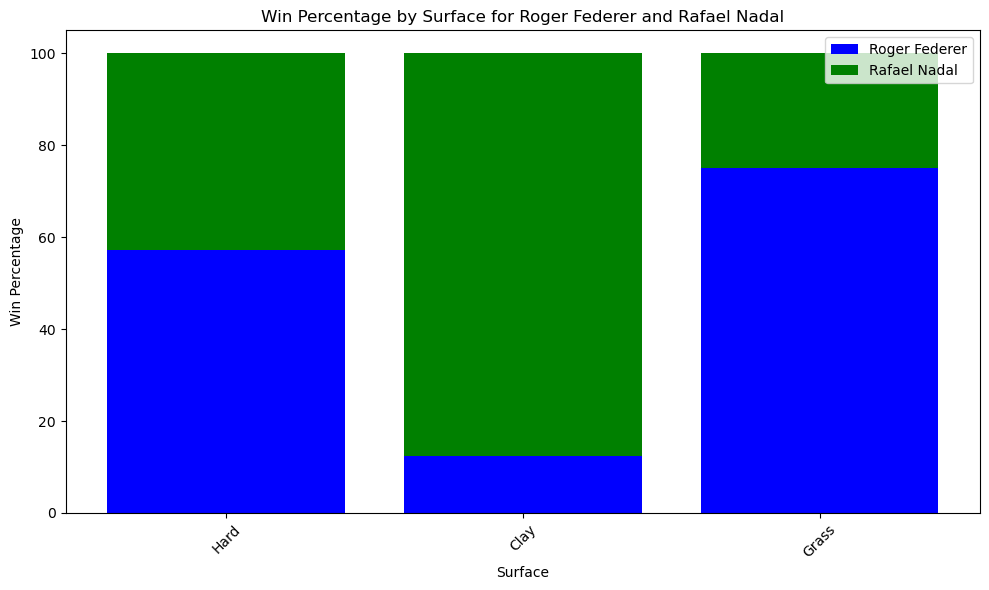

In [38]:
matches2 = matches.filter(
    ((matches.winner1_name == "Roger Federer") & (matches.loser1_name == "Rafael Nadal"))
     |
    ((matches.winner1_name == "Rafael Nadal")  & (matches.loser1_name == "Roger Federer"))
)
# total wins for each player on each surface
total_wins_surface = matches2.groupBy("surface").agg(
    spark_sum(F.when(matches2.winner1_name == "Roger Federer", 1).otherwise(0)).alias("total_wins_rf"),
    spark_sum(F.when(matches2.winner1_name == "Rafael Nadal", 1).otherwise(0)).alias("total_wins_rn")
)

# win percentages on different surfaces
surface_wins_rf = total_wins_surface.withColumn("win_percentage_rf", (total_wins_surface["total_wins_rf"] / (total_wins_surface["total_wins_rf"] + total_wins_surface["total_wins_rn"])) * 100)
surface_wins = surface_wins_rf.withColumn("win_percentage_rn", (total_wins_surface["total_wins_rn"] / (total_wins_surface["total_wins_rf"] + total_wins_surface["total_wins_rn"])) * 100)

print("Win percentage for Roger Federer by surface:")
surface_wins.show()
# getting surface names and win percentages for both players
surfaces = surface_wins.select("surface").rdd.map(lambda row: row[0]).collect()
win_percentages_rf = surface_wins.select("win_percentage_rf").rdd.map(lambda row: row[0]).collect()
win_percentages_rn = surface_wins.select("win_percentage_rn").rdd.map(lambda row: row[0]).collect()

plt.figure(figsize=(10, 6))
plt.bar(surfaces, win_percentages_rf, color='blue', label='Roger Federer')
plt.bar(surfaces, win_percentages_rn, color='green', label='Rafael Nadal', bottom=win_percentages_rf)
plt.xlabel('Surface')
plt.ylabel('Win Percentage')
plt.title('Win Percentage by Surface for Roger Federer and Rafael Nadal')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
matches1 = matches.withColumn('surface', when(matches['surface']=='Carpet', "Grass").otherwise(matches['surface']))

In [40]:
matches_federer = matches1.filter(
    ((matches1.winner1_name == "Roger Federer") | (matches1.loser1_name == "Roger Federer"))
)

wins_federer = matches_federer.filter(
    ((matches1.winner1_name == "Roger Federer") ))

matches_nadal = matches1.filter(
    ((matches1.winner1_name == "Rafael Nadal") | (matches1.loser1_name == "Rafael Nadal"))
)

wins_nadal = matches_nadal.filter(
    ((matches1.winner1_name == "Rafael Nadal") ))

matches_novak = matches1.filter(
    ((matches1.winner1_name == "Novak Djokovic") | (matches1.loser1_name == "Novak Djokovic"))
)

wins_novak = matches_novak.filter(
    ((matches1.winner1_name == "Novak Djokovic") ))
    
total_matches_surface_roger = matches_federer.groupBy("surface").count().alias('matches_count')
total_matches_surface_nadal = matches_nadal.groupBy("surface").count()
total_matches_surface_novak = matches_novak.groupBy("surface").count()

total_wins_surface_roger = wins_federer.groupBy("surface") \
  .count() \
  .withColumnRenamed("count", "win_count")

total_wins_surface_nadal = wins_nadal.groupBy("surface") \
  .count() \
  .withColumnRenamed("count", "win_count")

total_wins_surface_novak = wins_novak.groupBy("surface") \
  .count() \
  .withColumnRenamed("count", "win_count")

# win percentages for Federer
win_percentages_federer = total_wins_surface_roger.join(
    total_matches_surface_roger, on="surface"
).withColumn(
    "win_percentage_federer", F.col("win_count") / F.col("count") * 100
)

# win percentages Nadal (similar approach)
win_percentages_nadal = total_wins_surface_nadal.join(
    total_matches_surface_nadal, on="surface"
).withColumn(
    "win_percentage_nadal", F.col("win_count") / F.col("count") * 100
)

win_percentages_novak = total_wins_surface_novak.join(
    total_matches_surface_novak, on="surface"
).withColumn(
    "win_percentage_novak", F.col("win_count") / F.col("count") * 100
)

# Combine win percentages
combined_percentages = win_percentages_federer.select("surface", "win_percentage_federer")\
  .join(win_percentages_nadal.select("surface", "win_percentage_nadal"), on="surface") \
  .join(win_percentages_novak.select("surface", "win_percentage_novak"), on="surface")

combined_percentages.show()

+-------+----------------------+--------------------+--------------------+
|surface|win_percentage_federer|win_percentage_nadal|win_percentage_novak|
+-------+----------------------+--------------------+--------------------+
|   Clay|     73.45132743362832|   88.72785829307568|   78.98550724637681|
|  Grass|     80.81395348837209|   73.68421052631578|   81.60919540229885|
|   Hard|     82.01160541586073|   75.76974564926373|   81.03070175438597|
+-------+----------------------+--------------------+--------------------+



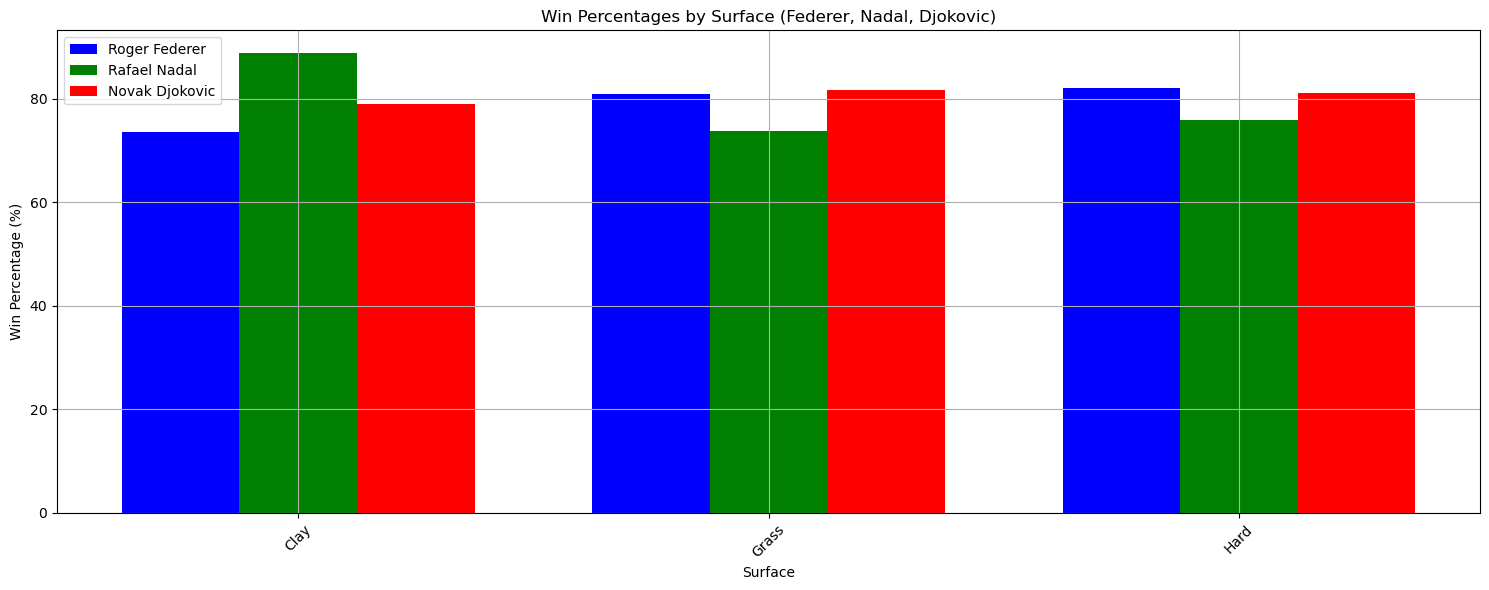

In [41]:
surfaces = combined_percentages.select("surface").distinct().rdd.flatMap(lambda x: x).collect()

federer_percentages = combined_percentages.select("win_percentage_federer").rdd.flatMap(lambda x: x).collect()
nadal_percentages = combined_percentages.select("win_percentage_nadal").rdd.flatMap(lambda x: x).collect()
novak_percentages = combined_percentages.select("win_percentage_novak").rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(15, 6))  # Adjust width for three players
bar_width = 0.25  # Adjust bar width for three players
num_players = 3
index = range(len(surfaces))

plt.bar(index, federer_percentages, bar_width, label='Roger Federer', color='b')
plt.bar([i + bar_width for i in index], nadal_percentages, bar_width, label='Rafael Nadal', color='g')
plt.bar([i + 2 * bar_width for i in index], novak_percentages, bar_width, label='Novak Djokovic', color='r')
plt.xlabel('Surface')
plt.ylabel('Win Percentage (%)')
plt.title('Win Percentages by Surface (Federer, Nadal, Djokovic)')
plt.xticks([i + bar_width * (num_players - 1) / 2 for i in index], surfaces, rotation=45)  # Adjust x-axis tick positions
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [42]:
avg_time_per_surface = matches.groupBy("surface").agg(avg("minutes").alias("avg_time"))
avg_time_per_surface_df = avg_time_per_surface.toPandas()
print(avg_time_per_surface_df)
avg_time_per_surface_df

  surface    avg_time
0  Carpet   91.618310
1    Clay  101.223521
2    Hard   97.559373
3   Grass  104.998727
4    None         NaN


,surface,avg_time
0,Carpet,91.618310
1,Clay,101.223521
2,Hard,97.559373
3,Grass,104.998727
4,None,NaN


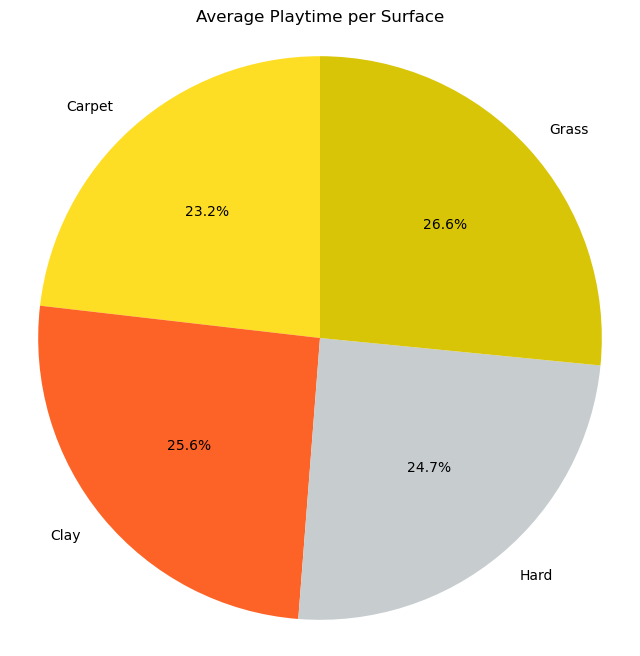

In [43]:
surfaces = avg_time_per_surface.select("surface").rdd.map(lambda row: row[0]).collect()
time = avg_time_per_surface.select("avg_time").rdd.map(lambda row: row[0]).collect()

valid_time = [t for t in time if isinstance(t, float) and not np.isnan(t)]

colors = ['#FEDE24', '#fd6326', '#c7cccf', '#d8c508']

plt.figure(figsize=(8, 8))
plt.pie(valid_time, labels=surfaces[:len(valid_time)], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Average Playtime per Surface')
plt.axis('equal')
plt.show()

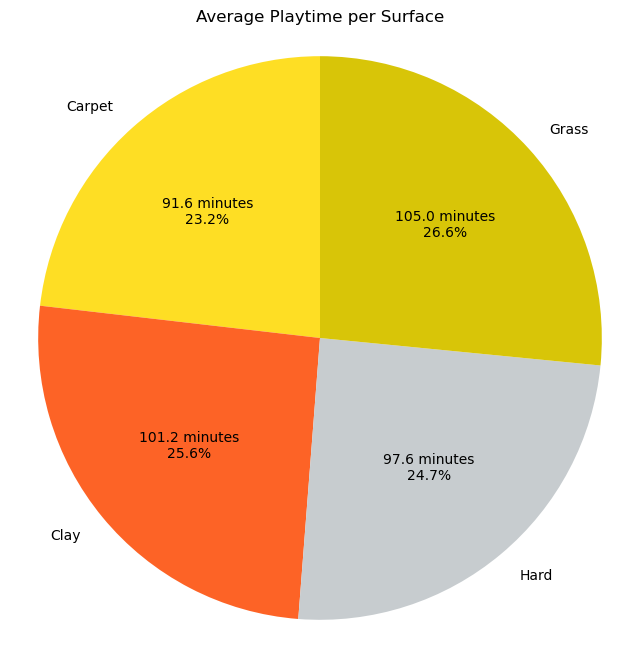

In [44]:
#add numerical time
plt.figure(figsize=(8, 8))
patches, texts, autotexts = plt.pie(valid_time, labels=surfaces[:len(valid_time)], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Average Playtime per Surface')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Adding numerical values and percentage as annotations
for i, (patch, autotext) in enumerate(zip(patches, autotexts)):
    time_value = valid_time[i]
    percentage = autotext.get_text()
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_text(f'{time_value:.1f} minutes\n{percentage}')

plt.show()

##### Top 3 players with the biggest winning percentage per surface

In [45]:
#Top 3 players with the biggest winning percentage per surface

matches_filtered = matches.filter(col("surface").isNotNull())
player_surface_stats = matches_filtered.groupBy("surface", "winner1_name")

# total matches for each player on each surface
player_surface_stats = matches_filtered.groupBy("surface", "winner1_name").agg(
    count("*").alias("total_matches")
)

# Defining a window specification to rank players by winning percentage within each surface
window_spec = Window.partitionBy("surface").orderBy(col("total_matches").desc())

# Ranking the players based on total matches for each surface
ranked_players_per_surface = player_surface_stats.withColumn(
    "rank", rank().over(window_spec)
)

# Filter to get the top 3 players per surface
top_3_players_per_surface = ranked_players_per_surface.filter(col("rank") <= 4)

top_3_players_per_surface.show()

+-------+--------------------+-------------+----+
|surface|        winner1_name|total_matches|rank|
+-------+--------------------+-------------+----+
| Carpet|       Jimmy Connors|          355|   1|
| Carpet|        John McEnroe|          352|   2|
| Carpet|          Ivan Lendl|          271|   3|
| Carpet|         Arthur Ashe|          258|   4|
| Carpet|        Boris Becker|          258|   4|
|   Clay|Ruben Ramirez Hid...|          682|   1|
|   Clay|     Guillermo Vilas|          676|   2|
|   Clay|      Carlos Berlocq|          626|   3|
|   Clay|      Manuel Orantes|          580|   4|
|  Grass|        Ken Rosewall|          216|   1|
|  Grass|       John Newcombe|          211|   2|
|  Grass|         Roy Emerson|          205|   3|
|  Grass|       Roger Federer|          201|   4|
|   Hard|       Roger Federer|          848|   1|
|   Hard|           Bob Bryan|          770|   2|
|   Hard|      Novak Djokovic|          739|   3|
|   Hard|         Yen Hsun Lu|          623|   4|


In [46]:
#that's not it. let's try differently
matches_filtered = matches.filter(col("surface").isNotNull())

player_surface_stats = matches_filtered.groupBy("surface", "winner1_name").agg(
    count("*").alias("total_wins")
)

player_surface_stats.show(2)

loser_surface_stats = matches_filtered.groupBy("surface", "loser1_name").agg(
    count("*").alias("total_losses")
)

loser_surface_stats.show(2)

+-------+---------------+----------+
|surface|   winner1_name|total_wins|
+-------+---------------+----------+
| Carpet|Tomas Carbonell|        18|
| Carpet|  Karel Novacek|        57|
+-------+---------------+----------+
only showing top 2 rows

+-------+---------------+------------+
|surface|    loser1_name|total_losses|
+-------+---------------+------------+
| Carpet|Tomas Carbonell|          33|
| Carpet|  Karel Novacek|          64|
+-------+---------------+------------+
only showing top 2 rows



In [47]:
# Join the winner and loser statistics
player_stats = player_surface_stats.join(
    loser_surface_stats,
    (player_surface_stats.surface == loser_surface_stats.surface) &
    (player_surface_stats.winner1_name == loser_surface_stats.loser1_name),
    "full_outer"
).groupBy(player_surface_stats.surface, player_surface_stats.winner1_name.alias("player_name")).agg(
    (sum(player_surface_stats.total_wins) + sum(loser_surface_stats.total_losses)).alias("total_games"),
    sum(player_surface_stats.total_wins).alias("total_wins")
)

player_stats = player_stats.filter(col('total_games') > 50)

player_stats.show(10)

+-------+--------------------+-----------+----------+
|surface|         player_name|total_games|total_wins|
+-------+--------------------+-----------+----------+
| Carpet|       Karel Novacek|        121|        57|
| Carpet|          Pavel Riha|         57|        31|
| Carpet|     Tomas Carbonell|         51|        18|
|   Clay|        Cyril Martin|         80|        35|
|   Clay|      Daniel Courcol|         76|        48|
|   Clay|         Ergun Zorlu|         70|        26|
|   Clay|        Frank Condor|        167|        88|
|   Clay|     Goncalo Pereira|         90|        25|
|   Clay|    Henrik Sillanpaa|        151|        70|
|   Clay|Ignacio Truyol Tu...|        116|        72|
+-------+--------------------+-----------+----------+
only showing top 10 rows



In [48]:
# winning percentage
player_stats = player_stats.withColumn("winning_percentage", round((col("total_wins") / col("total_games")) * 100, 2))

window_spec = Window.partitionBy(player_stats.surface).orderBy(player_stats.winning_percentage.desc())

# Assign ranks to players within each surface based on winning_percentage
player_stats_ranked = player_stats.withColumn("rank", rank().over(window_spec))

player_stats_filtered = player_stats_ranked.filter((col("rank") <=3))

# final result
player_stats_filtered.show()

+-------+-----------------+-----------+----------+------------------+----+
|surface|      player_name|total_games|total_wins|winning_percentage|rank|
+-------+-----------------+-----------+----------+------------------+----+
| Carpet|     John McEnroe|        417|       352|             84.41|   1|
| Carpet|       Ivan Lendl|        326|       271|             83.13|   2|
| Carpet|    Jimmy Connors|        437|       355|             81.24|   3|
|   Clay|Jean Rene Lacoste|         52|        47|             90.38|   1|
|   Clay|Henri Jean Cochet|         65|        58|             89.23|   2|
|   Clay|     Rafael Nadal|        621|       551|             88.73|   3|
|  Grass|        Don Budge|         71|        64|             90.14|   1|
|  Grass|       Fred Perry|        104|        93|             89.42|   2|
|  Grass|   Bill Tilden Ii|        130|       116|             89.23|   3|
|   Hard|       Ivan Lendl|        477|       394|              82.6|   1|
|   Hard|    Roger Federe

In [49]:
# Percentages of matches where a player loses the first set and wins the match (Bo3)

filtered_matches = matches.filter(col('best_of') == 3)

# Using regular expression to grab the 1st number of the column + the first number after the '-'
winner_score = regexp_extract(col("set_1"), r"(\d+)", 1).cast("int")
loser_score = regexp_extract(col("set_1"), r"-(\d+)", 1).cast("int")

# Filtering for the rows where the player lost the first set
lost_first_set_and_won_match = filtered_matches.filter(winner_score < loser_score)

remontada_count = lost_first_set_and_won_match.count()
total_count = filtered_matches.count()

win_percentage = '%.2f' % ((remontada_count / total_count) * 100)

print(f"Percentage of times where a player lost the first set in a best-of-3 game and ended up winning the match: {win_percentage}%")

Percentage of times where a player lost the first set in a best-of-3 game and ended up winning the match: 16.52%


In [50]:
# Percentages of matches where a player loses the first set and wins the match (Bo5)

filtered_matches = matches.filter(col('best_of') == 5)

# Using regular expression to grab the 1st number of the column + the first number after the '-'
winner_score_set1 = regexp_extract(col("set_1"), r"(\d+)", 1).cast("int")
loser_score_set1 = regexp_extract(col("set_1"), r"-(\d+)", 1).cast("int")
winner_score_set2 = regexp_extract(col("set_2"), r"(\d+)", 1).cast("int")
loser_score_set2 = regexp_extract(col("set_2"), r"-(\d+)", 1).cast("int")

# Filtering for the rows where the player lost the first set
lost_first_set_and_won_match = filtered_matches.filter((winner_score_set1 < loser_score_set1) & (winner_score_set2 < loser_score_set2))

remontada_count = lost_first_set_and_won_match.count()
total_count = filtered_matches.count()

win_percentage = '%.2f' % ((remontada_count / total_count) * 100)

print(f"Percentage of times where a player lost the first two sets in a best-of-5 game and ended up winning the match: {win_percentage}%")

Percentage of times where a player lost the first two sets in a best-of-5 game and ended up winning the match: 3.68%


#### Players with the biggest average of aces per match and their height

+--------------------+----------+------------------+
|        winner1_name|winner1_ht|avg_aces_per_match|
+--------------------+----------+------------------+
|        Ismar Gorcic|      NULL|23.333333333333332|
|        Ivo Karlovic|       208| 20.30878859857482|
|          Tyler Zink|      NULL|              19.0|
|          John Isner|       206|18.901768172888016|
|       Reilly Opelka|       211|18.550632911392405|
|        Heath Denman|       183|              18.0|
|Herbert Jody Magi...|      NULL|              18.0|
|          Jay Clarke|      NULL|              18.0|
|       Wayne Arthurs|       190|             17.35|
|       Scott Oudsema|       190|              17.0|
+--------------------+----------+------------------+



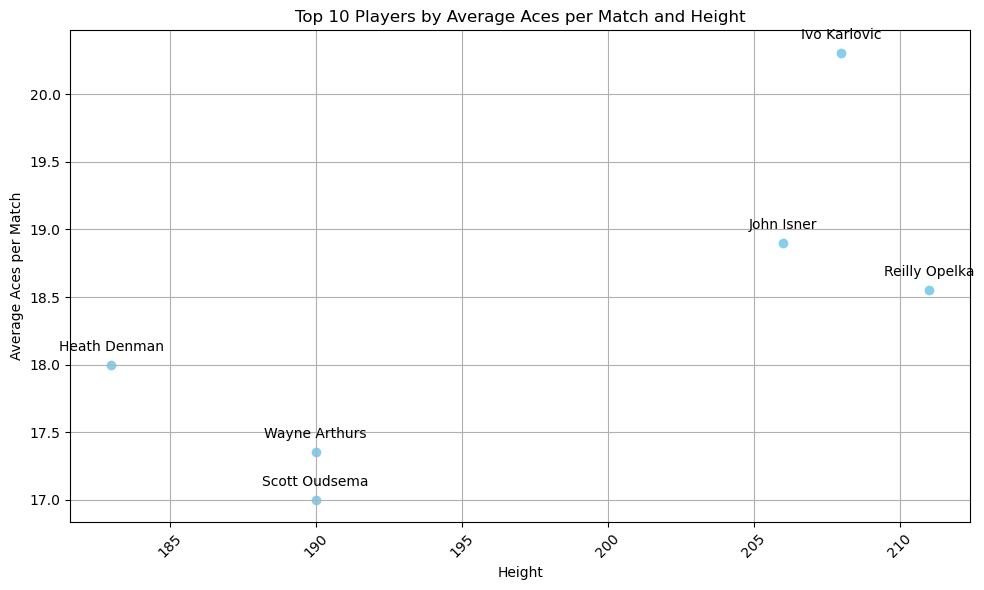

In [51]:
# Grouping by winner name and calculate the average number of aces per match
aces_per_match = matches.groupBy('winner1_name', 'winner1_ht') \
                        .agg(F.avg('w_ace').alias('avg_aces_per_match'))

top_players = aces_per_match.orderBy(F.desc('avg_aces_per_match')).limit(10)
top_players.show()


# ------ Plot --------

# Filter out missing values from player_height
player_names = [row['winner1_name'] for row in top_players.collect()]
avg_aces = [row['avg_aces_per_match'] for row in top_players.collect()]
player_height = [row['winner1_ht'] for row in top_players.collect()]

valid_indices = [i for i, height in enumerate(player_height) if height is not None]
player_names = [player_names[i] for i in valid_indices]
avg_aces = [avg_aces[i] for i in valid_indices]
player_height = [player_height[i] for i in valid_indices]

plt.figure(figsize=(10, 6))
plt.scatter(player_height, avg_aces, color='skyblue')

for i, txt in enumerate(player_names):
    plt.annotate(txt, (player_height[i], avg_aces[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Height')
plt.ylabel('Average Aces per Match')
plt.title('Top 10 Players by Average Aces per Match and Height')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### 5 oldest pairs (average age) winning a tournament.

+---------------+-------------+-----------------+
|   winner1_name| winner2_name|      average_age|
+---------------+-------------+-----------------+
|   Ivo Karlovic|Daniel Nestor|   42.35181382615|
|   Leander Paes|     Andre Sa|   41.77549623545|
|  Daniel Nestor| Leander Paes|41.55762649397308|
|James Cerretani|Daniel Nestor|   41.11293634495|
|James Cerretani| Leander Paes|    40.8090349076|
+---------------+-------------+-----------------+



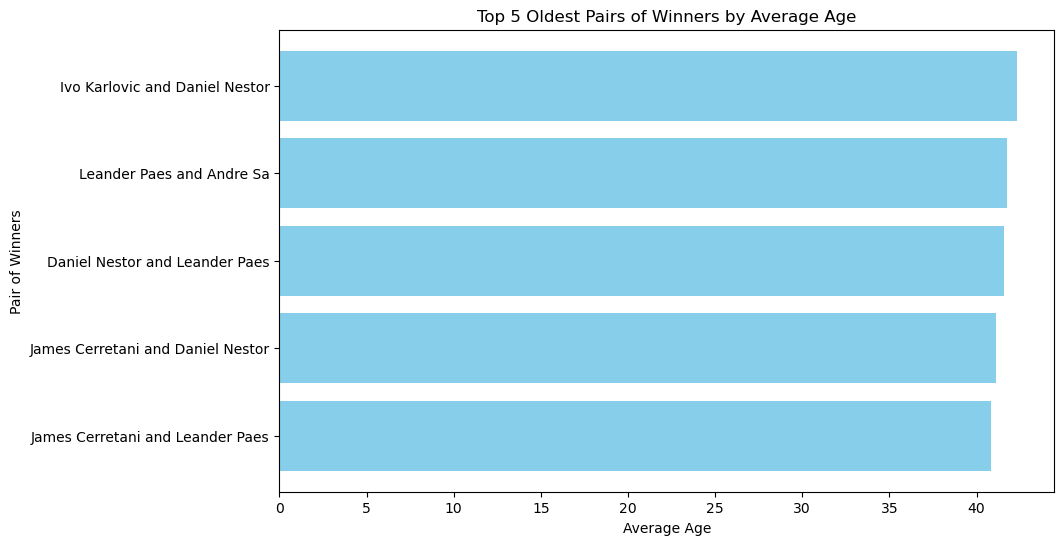

In [52]:
# Calculating the average age for each pair of winners in doubles matches
matches_doubles = matches.filter(col("Origin") == 'Doubles')
matches_doubles = matches_doubles.withColumn("avg_age", (F.col("winner1_age") + F.col("winner2_age")) / 2)

pairs_avg_age = matches_doubles.groupBy("winner1_name", "winner2_name").agg(F.avg("avg_age").alias("average_age"))
oldest_pairs = pairs_avg_age.orderBy(F.desc("average_age")).limit(5)
oldest_pairs.show()

oldest_pairs_df = oldest_pairs.toPandas()

pairs = oldest_pairs_df["winner1_name"] + " and " + oldest_pairs_df["winner2_name"]
average_age = oldest_pairs_df["average_age"]

plt.figure(figsize=(10, 6))
plt.barh(pairs, average_age, color='skyblue')
plt.xlabel('Average Age')
plt.ylabel('Pair of Winners')
plt.title('Top 5 Oldest Pairs of Winners by Average Age')
plt.gca().invert_yaxis()
plt.show()

#### Percentage of matches that have 3 sets.

In [53]:
total_matches = matches.count()

# Matches with 3 sets
matches_with_3_sets = matches.filter(expr("set_3 IS NOT NULL")).count()
percentage_3_sets = (matches_with_3_sets / total_matches) * 100
print(f"Percentage of matches with 3 sets: {percentage_3_sets:.2f}%")

Percentage of matches with 3 sets: 36.80%


#### How many times did Rafael Nadal lose two games in a row on Clay and how many games in total? (0 in hundreds)

In [54]:
rafael_matches = matches.filter((matches.loser1_name == 'Rafael Nadal'))
total_games_lost = rafael_matches.agg(F.sum('l_SvGms')).collect()[0][0]

rafael_losses_on_clay = rafael_matches.filter(rafael_matches.surface == 'Clay')

# window function to partition by the player's name and order by the tournament date
windowSpec = Window.partitionBy('loser1_name').orderBy('tourney_date')

# column to indicate if the player lost two games in a row
rafael_losses_on_clay = rafael_losses_on_clay.withColumn('consecutive_losses', 
                                                         F.when((F.lag('tourney_date').over(windowSpec) == F.col('tourney_date') - 1), 1).otherwise(0))

two_losses_in_row = rafael_losses_on_clay.filter(rafael_losses_on_clay.consecutive_losses == 1)
total_two_losses_in_row = two_losses_in_row.count()


print("Total games lost by Rafael Nadal:", total_games_lost)
print("Total instances of two consecutive losses on Clay:", total_two_losses_in_row)

Total games lost by Rafael Nadal: 2836
Total instances of two consecutive losses on Clay: 0


#### Top 10 games with longest duration and their final score

In [55]:
# Split the score column into winner and loser scores
matches_filtered = matches.withColumn('winner_score', F.split('score', '-').getItem(0))
matches_filtered = matches_filtered.withColumn('loser_score', F.split('score', '-').getItem(1))

game_durations = matches_filtered.groupBy('tourney_id', 'winner1_name', 'score', 'winner_score', 'loser_score') \
                        .agg(F.max('minutes').alias('max_duration'))

game_durations = game_durations.withColumn('max_duration_hours', game_durations['max_duration'] / 60)
top_longest_games = game_durations.orderBy(F.desc('max_duration')).limit(10)

top_longest_games.show()

+----------+--------------------+--------------------+------------+-----------+------------+------------------+
|tourney_id|        winner1_name|               score|winner_score|loser_score|max_duration|max_duration_hours|
+----------+--------------------+--------------------+------------+-----------+------------+------------------+
| 2018-7391|      Federico Coria|             6-4 6-3|           6|        4 6|        4756| 79.26666666666667|
| 2023-9542|Camilo Ugo Carabelli|      6-3 5-7 7-6(5)|           6|        3 5|        1531|25.516666666666666|
| 2016-7347|      Juan Pablo Paz|             6-2 6-1|           6|        2 6|        1392|              23.2|
| 2018-7015|       Federico Gaio|      6-4 6-7(6) 7-5|           6|        4 6|        1241|20.683333333333334|
| 2016-0447|        Dmitry Popko|             6-2 6-3|           6|        2 6|        1237|20.616666666666667|
| 2016-M001|       Gilles Muller|          7-6(5) 6-3|           7|     6(5) 6|        1146|            

#### Average ranking of winners and losers (finalists) per tournament type (tourney_level).

In [56]:
# Calculating average ranking of winners and finalists per tournament type
avg_ranking_per_type = matches.groupBy('tourney_level') \
    .agg(
        F.avg('winner1_rank').alias('avg_winner_rank'),
        F.avg('loser1_rank').alias('avg_loser_rank')
    )

avg_ranking_per_type.show()

+-------------+------------------+------------------+
|tourney_level|   avg_winner_rank|    avg_loser_rank|
+-------------+------------------+------------------+
|            F|  9.84879288437103|15.144853875476493|
|            M|52.782369971049214| 82.53227762803235|
|            D|262.78830718715795|387.00380476138713|
|            A| 92.73410764046152|143.27926820391295|
|            G| 93.89269283162413|136.63778158345409|
|            S|  656.462971366281| 829.0578240108748|
|           15| 810.4517775074345| 985.4744022130433|
|           25| 645.4676482202291| 853.7859510852568|
|            C|  262.144446733979| 336.1185596775714|
+-------------+------------------+------------------+



##### Show the top 3 winners for each tourney_level with an Winner rank supperior from the average

In [57]:
avg_winner_rank_per_type = matches.groupBy('tourney_level').agg(F.avg('winner1_rank').alias('avg_winner_rank'))

window = Window.partitionBy('tourney_level').orderBy(F.desc('winner1_rank'))

# Add a rank column based on winner1_rank in descending order
matches_with_rank = matches.withColumn('rank', F.rank().over(window))
matches_with_rank = matches_with_rank.join(avg_winner_rank_per_type, on='tourney_level')

filtered_players = matches_with_rank.filter(matches_with_rank['winner1_rank'] > matches_with_rank['avg_winner_rank'])
top_players_per_type = filtered_players.filter(filtered_players['rank'] <= 3)

distinct_top_players = top_players_per_type.select('tourney_level', 'winner1_name', 'winner1_rank').distinct()
distinct_top_players.show()

+-------------+--------------------+------------+
|tourney_level|        winner1_name|winner1_rank|
+-------------+--------------------+------------+
|            F|    Hamad Medjedovic|         110|
|            F|          Luca Nardi|         115|
|            F|  Abedallah Shelbayh|         185|
|            M|    David Nalbandian|        1403|
|            M|         Todd Martin|        1427|
|            D| Sharmal Dissanayake|        2018|
|            D|Antso Rakotondram...|        2018|
|            D|         Roberto Cid|        2091|
|            D|     Shahin Khaledan|        2101|
|            A|     Nino Serdarusic|        2128|
|            A|     Sebastian Lavie|        2152|
|            G|        Ian Flanagan|        1711|
|            G|       Edward Winter|        1768|
|            G|    Mitchell Krueger|        1917|
|            S|    Davide Galoppini|        2252|
|            S|    Santiago Maresca|        2255|
|            S|Mostafa Mohamed H...|        2257|


#### Top 5 youngest number 1 in the world and their age on that moment

In [58]:
number_1_players = matches.filter(matches['winner1_rank'] == 1)

# Group the data by player and find the minimum age when they were ranked number 1
youngest_number_1_players = number_1_players.groupby('winner1_name') \
    .agg(F.min('winner1_age').alias('age_when_number_1')) \
    .orderBy('age_when_number_1') \
    .limit(5)

youngest_number_1_players.show()

+--------------+-----------------+
|  winner1_name|age_when_number_1|
+--------------+-----------------+
|Carlos Alcaraz|             19.3|
|Lleyton Hewitt|             20.7|
|   Marat Safin|             20.8|
|  Andy Roddick|             21.1|
|   Jim Courier|             21.4|
+--------------+-----------------+



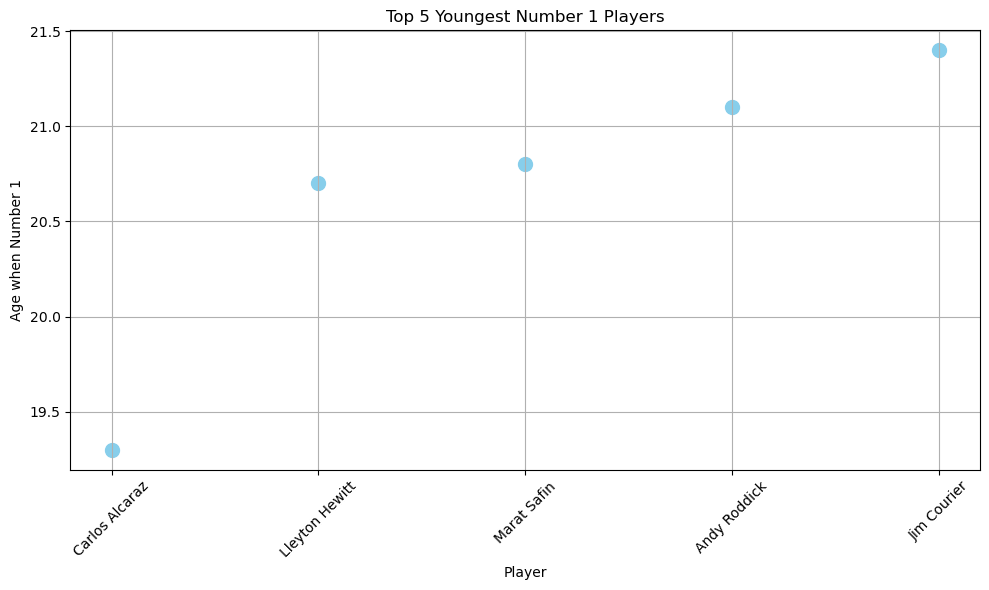

In [59]:
youngest_number_1_players_pd = youngest_number_1_players.toPandas()

plt.figure(figsize=(10, 6))
plt.scatter(youngest_number_1_players_pd['winner1_name'], youngest_number_1_players_pd['age_when_number_1'], s=100, color='skyblue')
plt.title('Top 5 Youngest Number 1 Players')
plt.xlabel('Player')
plt.ylabel('Age when Number 1')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Identifying nationalities with over 100 distinct winners within year groups (every 5 years)

In [71]:
matches_with_year = matches.withColumn('year', year('tourney_date'))
windowSpec = Window.partitionBy('year').orderBy('year').rowsBetween(-4, 0)

nationality_counts = matches_with_year.withColumn("year_group", F.floor(F.col('year') / 5) * 5).groupBy('year_group', 'winner1_ioc') \
    .agg(F.countDistinct('winner1_name').alias('count'))
nationality_counts = nationality_counts.withColumnRenamed('winner1_ioc', 'winner_nationality')


# Filter for the top 100 in each year group
top_100_nationalities = nationality_counts.orderBy(nationality_counts['count'].desc()) \
  .filter(nationality_counts['count'] > 100)
top_100_nationalities.show()

+----------+------------------+-----+
|year_group|winner_nationality|count|
+----------+------------------+-----+
|      1990|               USA|  375|
|      2015|               USA|  364|
|      1995|               USA|  350|
|      2010|               USA|  306|
|      2020|               USA|  289|
|      2000|               USA|  282|
|      2005|               USA|  268|
|      1980|               USA|  265|
|      1910|               USA|  259|
|      1985|               USA|  258|
|      2015|               FRA|  245|
|      2015|               ITA|  242|
|      1965|               USA|  242|
|      2010|               FRA|  228|
|      1905|               USA|  223|
|      1995|               GER|  223|
|      2020|               ITA|  219|
|      2000|               ESP|  215|
|      1975|               USA|  215|
|      2020|               FRA|  207|
+----------+------------------+-----+
only showing top 20 rows



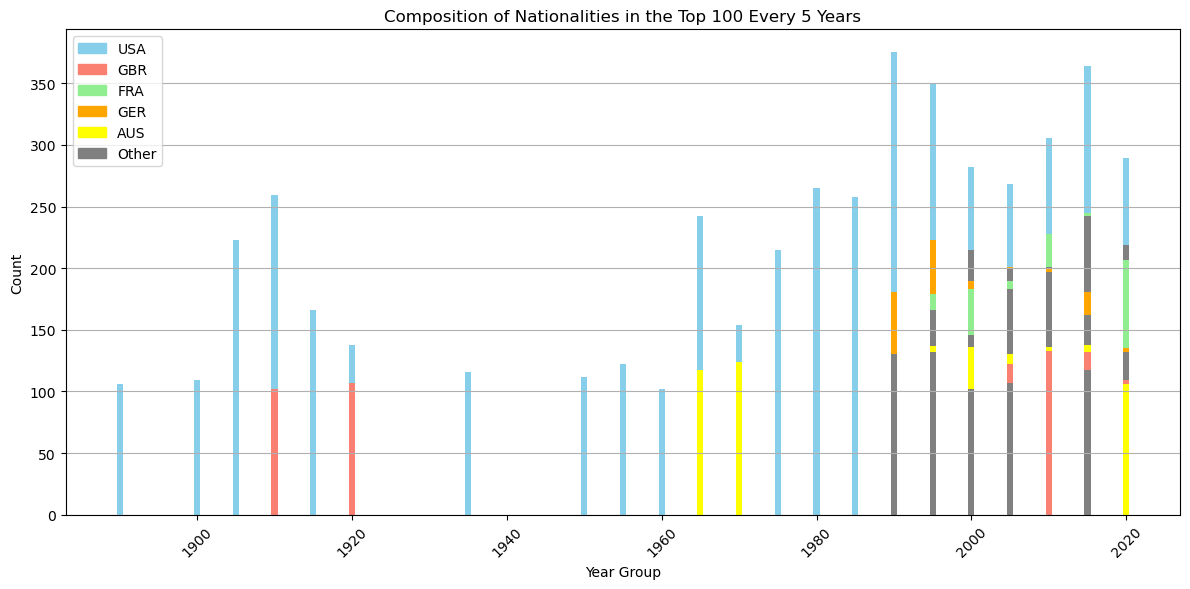

In [61]:
top_100_nationalities_pandas = top_100_nationalities.toPandas()
# Drop rows with missing or invalid values in the 'winner_nationality' column
top_100_nationalities_pandas = top_100_nationalities_pandas.dropna(subset=['winner_nationality'])

color_map = {'USA': 'skyblue', 'GBR': 'salmon', 'FRA': 'lightgreen', 'GER': 'orange', 'AUS': 'yellow'}

plt.figure(figsize=(12, 6))
bars = plt.bar(top_100_nationalities_pandas['year_group'], top_100_nationalities_pandas['count'],
               color=top_100_nationalities_pandas['winner_nationality'].map(color_map, na_action='ignore').fillna('grey'))
plt.title('Composition of Nationalities in the Top 100 Every 5 Years')
plt.xlabel('Year Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y')

legend_labels = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
legend_labels.append(plt.Rectangle((0,0),1,1, color='grey'))
color_map['Other'] = 'grey'
plt.legend(legend_labels, list(color_map.keys()) + ['Other'], loc='upper left')

plt.tight_layout()
plt.show()

In [64]:
number_1_players = original_matches.filter(original_matches['winner_rank'] == 1)
number_1_players.show(3)

+-------+-------+---------+-------+--------+--------+-------+-----+---------+---------+----+------+----------+-----------+---------+---------+----------+-----------------+-----------+------------------+----------+-----------+---------+---------+----------+-----------+-----------+------------------+---------+-----------+----------+--------+--------+---------+-----------------+----------+-----------------+----------+---------+-------+-----+-----------+-------+------------+----------+-------------+--------------+-------+--------+--------+-------+-----+---------+---------+----+------+-----------+------------+----------+----------+-----------+------------+------------+-------------------+-----------+------------+----------+----------+-----------+------------+------------+-------------------+----------+------------+-----------+---------+---------+----------+------------+-----------+------------------+-----------+-----+-----+-----+-----+-----+
| Origin|best_of|draw_size|l_1stIn|l_1stWon|l_2nd

In [66]:
num_1_count_df = number_1_players.groupBy("winner_name").agg(count(col("winner_name")).alias("num_1_count"))

ordered_df = num_1_count_df.orderBy(col("num_1_count").desc())

# top 5 players with the most number 1 occurrences
top_5_players = ordered_df.select("winner_name", "num_1_count").limit(5)

top_5_players.show()

+--------------+-----------+
|   winner_name|num_1_count|
+--------------+-----------+
|Novak Djokovic|        473|
| Roger Federer|        434|
|    Ivan Lendl|        365|
|  Pete Sampras|        338|
| Jimmy Connors|        302|
+--------------+-----------+



In [68]:
number_1_players = original_matches.filter(original_matches['winner_rank'] == 1)
df = number_1_players.withColumn("tourney_date", 
                             to_date(col("tourney_date"), "yyyyMMdd")) \
                             .select('winner_name', 'tourney_date')

df = df.orderBy(col("tourney_date").asc())


window_spec = Window.orderBy("tourney_date")

# Added a lagged column to compare consecutive rows
df = df.withColumn("prev_player", lag("winner_name").over(window_spec))

# Mark the start of a new consecutive period when the player changes or is null (indicating the first row)
df = df.withColumn("start_period", 
     when((col("winner_name") != col("prev_player")) | (col("prev_player").isNull()), 
          col("tourney_date")).otherwise(None))

df = df.dropna()


window_spec = Window.partitionBy("winner_name").orderBy("start_period")

# added a lagged column to get the start_period value from the next row per player
df = df.withColumn("next_start_period", lag("start_period").over(window_spec))

# getting the period duration by subtracting the next row's start_period from the current row's start_period
df = df.withColumn("period", (col("start_period") - col("next_start_period")).cast("integer"))

df = df.drop("next_start_period")
df = df.dropna()
df = df.orderBy(df["period"].desc())
df = df.withColumnRenamed('winner_name', 'player')
df.select('player', 'period').show()

+--------------+------+
|        player|period|
+--------------+------+
| Roger Federer|  2049|
| Roger Federer|  2012|
| Jimmy Connors|  1757|
|  Andre Agassi|  1638|
|Novak Djokovic|  1561|
|  Rafael Nadal|  1421|
|  Andre Agassi|  1358|
|    Ivan Lendl|  1268|
|  Rafael Nadal|  1218|
| Jimmy Connors|  1211|
| Roger Federer|  1080|
|Novak Djokovic|   784|
|  Pete Sampras|   757|
|  Pete Sampras|   742|
|  Rafael Nadal|   651|
|Novak Djokovic|   637|
|  John McEnroe|   505|
|   Jim Courier|   504|
|  Rafael Nadal|   497|
|Novak Djokovic|   469|
+--------------+------+
only showing top 20 rows



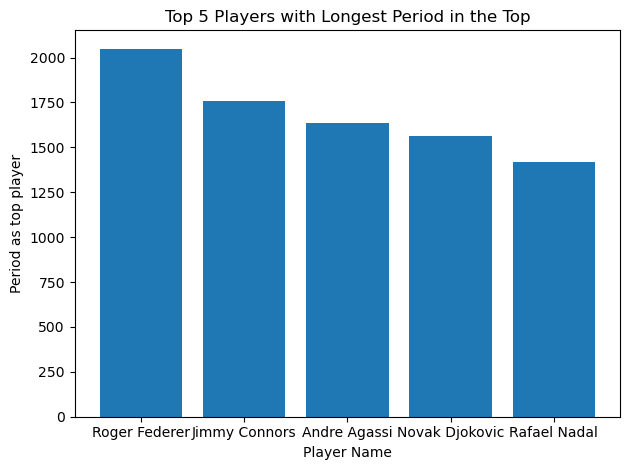

In [69]:
names = ['Roger Federer', 'Jimmy Connors', 'Andre Agassi', 'Novak Djokovic', 'Rafael Nadal']
values = [2049, 1757, 1638, 1561, 1421]

plt.bar(names, values)

plt.xlabel('Player Name')
plt.ylabel('Period as top player')
plt.title('Top 5 Players with Longest Period in the Top')
plt.tight_layout()
plt.show()

## Queries for the Ranking file

In [72]:
rankings =spark.read.option("header","true").option("inferSchema","true") \
.csv('rankings')

#convert ranking_date to datetype column
rankings = rankings.withColumn("ranking_date", 
                         to_date(col("ranking_date").cast("string"), "yyyyMMdd"))

rankings.show(5)

+------------+----+------+------+
|ranking_date|rank|player|points|
+------------+----+------+------+
|  2020-01-06|   1|104745|  9985|
|  2020-01-06|   2|104925|  9055|
|  2020-01-06|   3|103819|  6590|
|  2020-01-06|   4|106233|  5825|
|  2020-01-06|   5|106421|  5705|
+------------+----+------+------+
only showing top 5 rows



In [73]:
#Obtain the most recent date
most_recent_date = rankings.select(F.max("ranking_date")).collect()[0][0]
most_recent_date

datetime.date(2024, 1, 1)

In [74]:
top_5 = rankings.filter(rankings.ranking_date == most_recent_date) \
                      .orderBy("rank") \
                      .limit(5)
top_5.show()

+------------+----+------+------+
|ranking_date|rank|player|points|
+------------+----+------+------+
|  2024-01-01|   1|104925| 11245|
|  2024-01-01|   2|207989|  8855|
|  2024-01-01|   3|106421|  7600|
|  2024-01-01|   4|206173|  6490|
|  2024-01-01|   5|126094|  4805|
+------------+----+------+------+



In [75]:
players = top_5.select("player").distinct() #select players
ranks_top5 = rankings.join(players, "player") \
                           .filter(rankings.ranking_date >= "2010-01-01") \
                           .orderBy("ranking_date")


ranks_top5.show(10)

+------+------------+----+------+
|player|ranking_date|rank|points|
+------+------------+----+------+
|104925|  2010-01-04|   3|  8310|
|104925|  2010-01-11|   3|  8310|
|104925|  2010-01-18|   3|  8310|
|104925|  2010-01-25|   3|  8310|
|104925|  2010-02-01|   2|  8310|
|104925|  2010-02-08|   2|  8310|
|104925|  2010-02-15|   2|  8310|
|104925|  2010-02-22|   2|  8310|
|104925|  2010-03-01|   2|  8310|
|104925|  2010-03-08|   2|  8310|
+------+------------+----+------+
only showing top 10 rows



In [76]:
singles = spark.read.option("header","true").option("inferSchema","true") \
.csv('singles')
rankings_with_names = ranks_top5.join(singles, ranks_top5.player == singles.winner_id, "left") \
                                        .select(ranks_top5["*"], singles["winner_name"].alias("player_name")) \
                                        .dropDuplicates()
rankings_with_names.show(5)

+------+------------+----+------+--------------+
|player|ranking_date|rank|points|   player_name|
+------+------------+----+------+--------------+
|206173|  2020-10-19|  46|  1136| Jannik Sinner|
|104925|  2021-08-30|   1| 11113|Novak Djokovic|
|104925|  2021-11-29|   1| 11540|Novak Djokovic|
|104925|  2021-11-22|   1| 11540|Novak Djokovic|
|206173|  2022-03-07|  10|  3495| Jannik Sinner|
+------+------------+----+------+--------------+
only showing top 5 rows



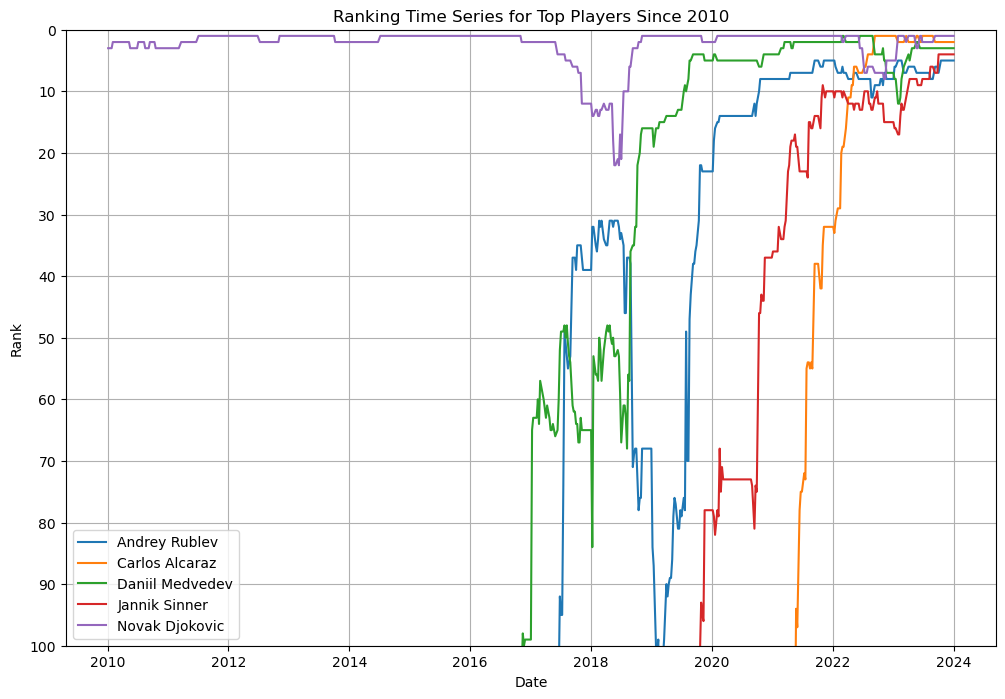

In [77]:
ranks_pd = rankings_with_names.toPandas()

pivoted = ranks_pd.pivot(index='ranking_date', columns='player_name', values='rank')


plt.figure(figsize=(12, 8))
for player in pivoted.columns:
    plt.plot(pivoted.index, pivoted[player], label=player)
plt.ylim(0, 100)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.title('Ranking Time Series for Top Players Since 2010')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [78]:
rankings_with_names = rankings_with_names.filter(rankings.ranking_date >= "2021-01-01") \
                           .orderBy("ranking_date")
rankings_with_names.show(5)

+------+------------+----+------+---------------+
|player|ranking_date|rank|points|    player_name|
+------+------------+----+------+---------------+
|106421|  2021-01-04|   4|  8470|Daniil Medvedev|
|104925|  2021-01-04|   1| 12030| Novak Djokovic|
|126094|  2021-01-04|   8|  4164|  Andrey Rublev|
|206173|  2021-01-04|  36|  1464|  Jannik Sinner|
|207989|  2021-01-04| 141|   464| Carlos Alcaraz|
+------+------------+----+------+---------------+
only showing top 5 rows



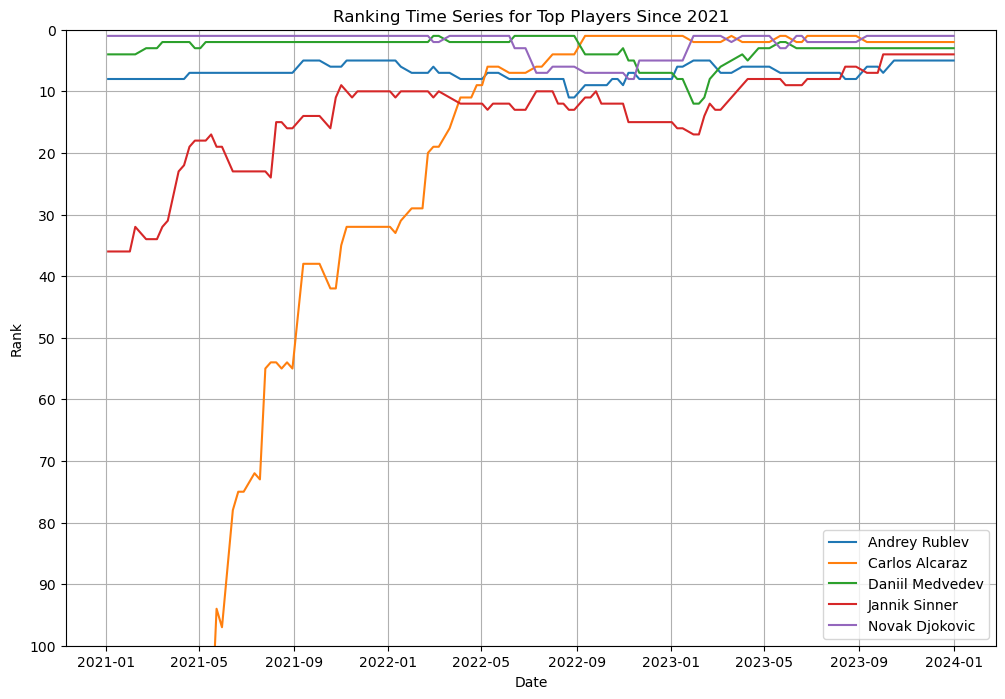

In [79]:
ranks_pd = rankings_with_names.toPandas()

pivoted = ranks_pd.pivot(index='ranking_date', columns='player_name', values='rank')


plt.figure(figsize=(12, 8))
for player in pivoted.columns:
    plt.plot(pivoted.index, pivoted[player], label=player)
plt.ylim(0, 100)
plt.gca().invert_yaxis()
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.title('Ranking Time Series for Top Players Since 2021')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.legend(loc='best')
plt.grid(True)
plt.show()